## ADSP 32018 Natural Language Processing and Cognitive Computing¶
### Final Project

In [1]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np


import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import multiprocessing
import string

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [7]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 13.2 s, sys: 18 s, total: 31.1 s
Wall time: 4min 30s


/Users/yifan_/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


(200435, 5)

In [8]:
# Extract sampled data
sampled_df = df_news_final_project.sample(frac=0.1)

### Data cleaning

In [9]:
# Filter english result
sampled_df=sampled_df[sampled_df['language']=='en']

# clean duplicate values
sampled_df.drop_duplicates(subset=['text'], inplace=True)

# Filter articles with less than 20 words
sampled_df[sampled_df['text'].apply(lambda x: len(x.split()) >= 20)]

# Eliminate newlines, tabs
sampled_df['text'] = sampled_df['text'].replace({r'\n': '', r'\t': ''}, regex=True)

In [10]:
# Define relevant keywords related to AI impact
relevant_keywords = ['data science', 'machine learning', 'artificial intelligence', 'ai']

# Function to check if an article is relevant based on keywords
def is_relevant(article_text, relevant_keywords):
    for keyword in relevant_keywords:
        if keyword in article_text.lower():
            return True
    return False

# Filter relevant articles
relevant_articles = sampled_df[sampled_df['text'].apply(lambda x: is_relevant(x, relevant_keywords))]
relevant_articles = relevant_articles[['date','title','text']]

In [11]:
stop_words = stopwords.words('english')

# Define functions for stopwords

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# function to remove Links, Emails, and URLs
def remove_links(text):
    # remove links
    text = re.sub(r'http\S+', '', str(text))
    # remove emails
    text = re.sub(r'\S*@\S*\s?', '', str(text))
    # remove URLs
    text = re.sub(r'www\S+', '', str(text))

    return text

# function to remove special characters from a sentence
def remove_spc_char(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return cleaned_text

In [12]:
# Clean links
relevant_articles.loc[:, 'text'] = relevant_articles['text'].apply(remove_links)

# Clean stopwords
relevant_articles.loc[:, 'text'] = relevant_articles['text'].apply(remove_stopwords)

# Clean special characters
relevant_articles.loc[:, 'text'] = relevant_articles['text'].apply(remove_spc_char)

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [13]:
# Change into tokens
text_list = relevant_articles['text'].tolist()
text_tokens = list(sent_to_words(text_list))

In [14]:
# Function to make ngrams from original tokens
def make_bigrams(texts):
    # Bigram
    bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    # Bigram
    bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=1)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [15]:
# Make bigrams and trigrams
text_bigrams = make_bigrams(text_tokens)
text_trigrams = make_trigrams(text_tokens)

In [16]:
# Combine tokens and ngrams
relevant_articles['text_tokens'] = list(zip(text_tokens, text_bigrams, text_trigrams))
relevant_articles['text_tokens'] = relevant_articles['text_tokens'].apply(lambda x: list(x[0] + x[1] + x[2]))

In [17]:
# Function to lemmatize words
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Lemmatize text keeping only noun, adj, vb, adv
text_lemmatized = lemmatization(text_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

relevant_articles['text_lemmatized'] = text_lemmatized

### LDA (Topic Detection)

In [41]:
# supporting function
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [42]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
text_lemmatized = relevant_articles['text_lemmatized'].tolist()
dictionary = corpora.Dictionary(text_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_lemmatized]

In [43]:
# Tuning N (the number of topics)
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter

beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [doc_term_matrix]
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
                    
lda_tuning = pd.DataFrame(model_results)

LDA will execute 11 iterations
Completed model based on 5 LDA topics. Finished 9.1% of LDA runs
Completed model based on 6 LDA topics. Finished 18.2% of LDA runs
Completed model based on 7 LDA topics. Finished 27.3% of LDA runs
Completed model based on 8 LDA topics. Finished 36.4% of LDA runs
Completed model based on 9 LDA topics. Finished 45.5% of LDA runs
Completed model based on 10 LDA topics. Finished 54.5% of LDA runs
Completed model based on 11 LDA topics. Finished 63.6% of LDA runs
Completed model based on 12 LDA topics. Finished 72.7% of LDA runs
Completed model based on 13 LDA topics. Finished 81.8% of LDA runs
Completed model based on 14 LDA topics. Finished 90.9% of LDA runs
Completed model based on 15 LDA topics. Finished 100.0% of LDA runs


In [44]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 6, Alpha: asymmetric, Beta: auto


In [45]:
tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=text_lemmatized, dictionary=dictionary, coherence='c_v')

In [46]:
print(*tuned_lda_model.print_topics(), sep='\n')

(0, '0.061*"market" + 0.020*"report" + 0.017*"intelligence" + 0.015*"artificial" + 0.014*"analysis" + 0.013*"global" + 0.013*"growth" + 0.012*"ai" + 0.011*"industry" + 0.010*"forecast"')
(1, '0.024*"ai" + 0.008*"datum" + 0.008*"technology" + 0.006*"customer" + 0.006*"business" + 0.006*"solution" + 0.006*"company" + 0.006*"use" + 0.006*"provide" + 0.005*"medium"')
(2, '0.013*"say" + 0.011*"ago" + 0.009*"ai" + 0.008*"hour" + 0.006*"use" + 0.006*"day" + 0.006*"new" + 0.005*"news" + 0.005*"public" + 0.004*"technology"')
(3, '0.019*"ai" + 0.009*"company" + 0.009*"stock" + 0.009*"market" + 0.006*"technology" + 0.005*"datum" + 0.005*"business" + 0.005*"use" + 0.005*"intelligence" + 0.004*"say"')
(4, '0.009*"share" + 0.008*"patient" + 0.007*"communication" + 0.006*"health" + 0.006*"use" + 0.005*"digi" + 0.005*"company" + 0.005*"new" + 0.005*"ai" + 0.005*"report"')
(5, '0.012*"ai" + 0.009*"use" + 0.007*"new" + 0.007*"say" + 0.005*"make" + 0.005*"get" + 0.004*"work" + 0.004*"chatgpt" + 0.004*"go

In [59]:
vis_data = pyLDAvis.gensim.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, n_jobs=1)
pyLDAvis.display(vis_data)

In [61]:
pyLDAvis.save_html(vis_data, 'lda_display.html')

## Sentiment Analysis

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

In [16]:
yelp = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/yelp/yelp_train_sentiment.json', orient='records', lines=True)
yelp.shape

(255717, 3)

In [17]:
# define X and y
X = yelp['text']
y = yelp['label']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (255717,)
y Shape: (255717,)


In [18]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (191787,) y_train: (191787,)
Testing records, X_test: (63930,) y_test: (63930,)


In [19]:
# Initialize vectorizer
vect = CountVectorizer()

vect = CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3))

#### Naive Bayes Model

In [32]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(vect.fit_transform(X_train), y_train)

MultinomialNB()

In [33]:
# make class predictions
y_pred = nb.predict(vect.transform(X_test))
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")

Test Accuracy: 94.8%


In [34]:
# calculate precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     32217
           1       0.97      0.92      0.95     31713

    accuracy                           0.95     63930
   macro avg       0.95      0.95      0.95     63930
weighted avg       0.95      0.95      0.95     63930



In [35]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[31430   787]
 [ 2509 29204]]


#### Logistic Regression Model

In [38]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=200)
logreg.fit(vect.fit_transform(X_train), y_train)

LogisticRegression(max_iter=200)

In [39]:
# make class predictions
y_pred = logreg.predict(vect.transform(X_test))

In [40]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")

Test Accuracy: 97.3%


In [41]:
# calculate precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32217
           1       0.97      0.97      0.97     31713

    accuracy                           0.97     63930
   macro avg       0.97      0.97      0.97     63930
weighted avg       0.97      0.97      0.97     63930



In [42]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[31396   821]
 [  892 30821]]


#### Support Vector Machine

In [21]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)
svm.fit(vect.fit_transform(X_train), y_train)

SGDClassifier(max_iter=100, tol=None)

In [ ]:
# make class predictions
y_pred = svm.predict(vect.transform(X_test))

In [134]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")

Test Accuracy: 97.4%


In [135]:
# calculate precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32217
           1       0.97      0.97      0.97     31713

    accuracy                           0.97     63930
   macro avg       0.97      0.97      0.97     63930
weighted avg       0.97      0.97      0.97     63930



In [136]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[31403   814]
 [  870 30843]]


##### The accuracy of SVM model is the highest. So I decide to use SVM model to predict

#### Predict sentiment for articles

In [22]:
# vectorize the text using tfidf
new_text_data = df_news_final_project['text']

In [23]:
# make class predictions
y_pred = svm.predict(vect.transform(new_text_data))

In [24]:
# Add the predictions to the relevant_articles DataFrame
df_news_final_project['predicted_category'] = y_pred

In [94]:
# Select columns needed to plot
sentiment_df = df_news_final_project[['predicted_category','date']]
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# Change the date column as the format like year-month
sentiment_df['month'] = sentiment_df['date'].dt.strftime('%Y-%m')

/var/folders/0l/zxpjg129277430c329bg5xkm0000gn/T/ipykernel_15466/1463216029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
/var/folders/0l/zxpjg129277430c329bg5xkm0000gn/T/ipykernel_15466/1463216029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['month'] = sentiment_df['date'].dt.strftime('%Y-%m')


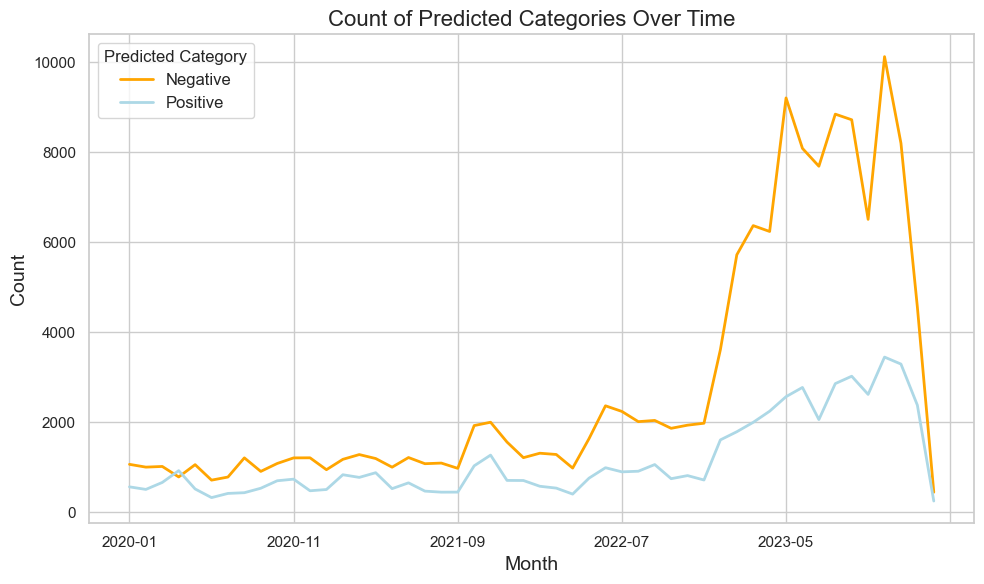

In [440]:
import matplotlib.pyplot as plt

# Group by 'month' and 'predicted_category' and count the occurrences
grouped = sentiment_df.groupby(['month', 'predicted_category']).size().unstack()

# Plot the line chart with smooth lines
grouped.plot(kind='line', figsize=(10, 6), linewidth=2, color=['orange', 'lightblue'])

# Set plot title and labels
plt.title('Count of Predicted Categories Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add legend with custom labels
plt.legend(labels=['Negative', 'Positive'], title='Predicted Category', fontsize=12)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

### NLI

In [2]:
import ktrain
zsl = ktrain.text.ZeroShotClassifier()

/Users/yifan_/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [39]:
labels = [
    "Healthcare",
    "Finance",
    "Manufacturing",
    "Automotive",
    "Telecommunications",
    "Entertainment",
    "Transportation",
    "Construction",
    "Hospitality",
    "Real Estate",
    "Media"
]
labels_len=len(labels)

In [25]:
# get a sample
df_news_positive=df_news_final_project[df_news_final_project['predicted_category']==1].sample(1000)
df_news_negative=df_news_final_project[df_news_final_project['predicted_category']==0].sample(1000)

In [52]:
df_news_positive1=df_news_positive.sample(100)

In [53]:
df_news_negative1=df_news_negative.sample(100)

In [54]:
# Set the hyppothesis template
hypothesis_template = "The topic of this news article is {}."

topic_positive = zsl.predict(df_news_positive1['text'].to_list(), 
                        labels=labels, 
                        include_labels=False, 
                        nli_template=hypothesis_template, 
                        batch_size=labels_len)
positive_df = pd.DataFrame(topic_positive, columns=labels) 

In [55]:
topic_negative = zsl.predict(df_news_negative1['text'].to_list(), 
                        labels=labels, 
                        include_labels=False, 
                        nli_template=hypothesis_template, 
                        batch_size=labels_len)
negative_df = pd.DataFrame(topic_negative, columns=labels) 

In [82]:
# positive dataframe
df_news_positive1['index'] = range(1, len(df_news_positive1) + 1)
positive_df['index'] = range(1, len(positive_df) + 1)
pos_news_topics = df_news_positive1.merge(positive_df, how='left', on='index')
pos_news_topics = pos_news_topics[['text', 'predicted_category'] + labels]

# Reset multi-level index
pos_news_topics.columns = pos_news_topics.columns.get_level_values(0)

# Select the small-ish articles only
pos_news_topics.head(5)

,text,predicted_category,Healthcare,Finance,Manufacturing,Automotive,Telecommunications,Entertainment,Transportation,Construction,Hospitality,Real Estate,Media
0,\nChatGPT powers live translation feature of S...,1,0.084107,0.035615,0.061923,0.020960,0.518392,0.915957,0.031563,0.044598,0.314503,0.003798,0.522287
1,\n\nGmail on mobile is using AI to save you ti...,1,0.342244,0.338700,0.265754,0.182419,0.764891,0.788897,0.369140,0.276525,0.719750,0.115990,0.934884
2,\n\n\n Cathie Wood’s Top Fund Missed Nvid...,1,0.063144,0.320837,0.143883,0.220116,0.251792,0.039282,0.078765,0.062105,0.060068,0.014575,0.315441
3,\n AI Data Management Market worth $70.2 bill...,1,0.002174,0.001890,0.002211,0.004394,0.011266,0.000743,0.003478,0.001100,0.004859,0.000608,0.041321
4,\n\n \n\n \nLove K-pop star Mark Tuan’s new ...,1,0.151703,0.023745,0.042728,0.731483,0.116137,0.325992,0.322630,0.024251,0.388405,0.563059,0.425786


In [85]:
# If the score is more than 0.8, then relevant
pos_news_topics[labels] = pos_news_topics[labels].applymap(lambda x: 1 if x >= 0.8 else 0)
pos_news_topics.head(5)

,text,predicted_category,Healthcare,Finance,Manufacturing,Automotive,Telecommunications,Entertainment,Transportation,Construction,Hospitality,Real Estate,Media
0,\nChatGPT powers live translation feature of S...,1,0,0,0,0,0,1,0,0,0,0,0
1,\n\nGmail on mobile is using AI to save you ti...,1,0,0,0,0,0,0,0,0,0,0,1
2,\n\n\n Cathie Wood’s Top Fund Missed Nvid...,1,0,0,0,0,0,0,0,0,0,0,0
3,\n AI Data Management Market worth $70.2 bill...,1,0,0,0,0,0,0,0,0,0,0,0
4,\n\n \n\n \nLove K-pop star Mark Tuan’s new ...,1,0,0,0,0,0,0,0,0,0,0,0


In [95]:
pos_score = pd.DataFrame(pos_news_topics[labels].sum(axis=0)).reset_index()
pos_score.columns = ['topic', 'count']
pos_score['score'] = round(pos_score['count'] / pos_news_topics.shape[0], 2)
pos_score = pos_score.sort_values(by='score', ascending=False)
pos_score

,topic,count,score
10,Media,41,0.41
4,Telecommunications,19,0.19
1,Finance,12,0.12
0,Healthcare,10,0.10
5,Entertainment,10,0.10
3,Automotive,8,0.08
6,Transportation,8,0.08
8,Hospitality,8,0.08
2,Manufacturing,5,0.05
7,Construction,2,0.02


/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


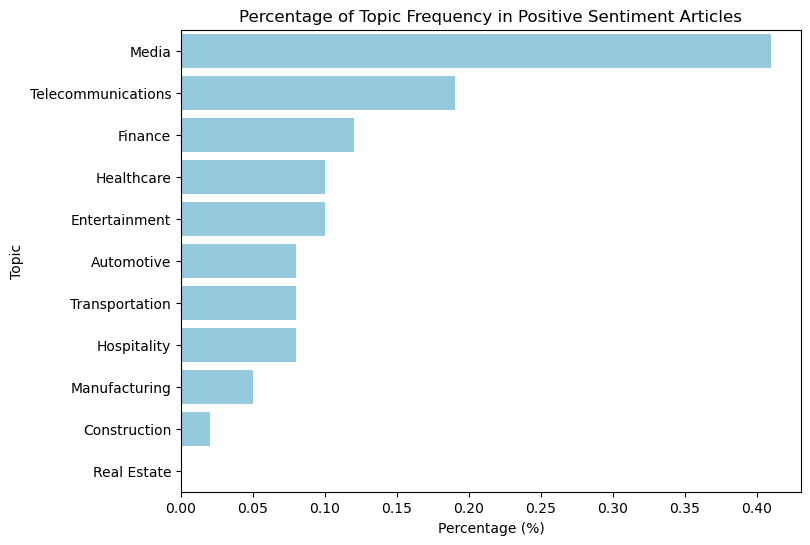

In [110]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the bar chart using Seaborn
sns.barplot(x='score', y='topic', data=pos_score.sort_values(by='score', ascending=False), color='skyblue')

# Add title and labels
plt.title('Percentage of Topic Frequency in Positive Sentiment Articles')
plt.xlabel('Percentage (%)')
plt.ylabel('Topic')

# Show the plot
plt.show()

In [83]:
# negative dataframe
df_news_negative1['index'] = range(1, len(df_news_negative1) + 1)
negative_df['index'] = range(1, len(negative_df) + 1)
neg_news_topics = df_news_negative1.merge(negative_df, how='left', on='index')
neg_news_topics = neg_news_topics[['text', 'predicted_category'] + labels]

# Reset multi-level index
neg_news_topics.columns = neg_news_topics.columns.get_level_values(0)

# Select the small-ish articles only
neg_news_topics.head(5)

,text,predicted_category,Healthcare,Finance,Manufacturing,Automotive,Telecommunications,Entertainment,Transportation,Construction,Hospitality,Real Estate,Media
0,\n\nOutsmarting humans just one step for AI vi...,0,0.196360,0.044098,0.041553,0.216438,0.290280,0.670309,0.078193,0.028293,0.059813,0.103308,0.882154
1,CVPR 2022 Program to Reveal New Research on Co...,0,0.771547,0.053964,0.053613,0.086869,0.272587,0.102970,0.104784,0.022514,0.119035,0.005335,0.839431
2,OpenAI CEO Sam Altman unleashed ChatGPT. Silic...,0,0.080145,0.236729,0.037722,0.036590,0.798246,0.429315,0.722142,0.050014,0.192253,0.026407,0.859749
3,"C3.ai stock pops, company raises outlook amid ...",0,0.026618,0.882686,0.061622,0.012209,0.036171,0.025535,0.011684,0.057314,0.017391,0.006061,0.372219
4,Embrace Pet Insurance Launches Modern Approach...,0,0.934849,0.432278,0.259672,0.180858,0.906536,0.810950,0.311251,0.073011,0.689916,0.029407,0.988476


In [86]:
# If the score is more than 0.8, then relevant
neg_news_topics[labels] = neg_news_topics[labels].applymap(lambda x: 1 if x >= 0.8 else 0)
neg_news_topics.head(5)

,text,predicted_category,Healthcare,Finance,Manufacturing,Automotive,Telecommunications,Entertainment,Transportation,Construction,Hospitality,Real Estate,Media
0,\n\nOutsmarting humans just one step for AI vi...,0,0,0,0,0,0,0,0,0,0,0,1
1,CVPR 2022 Program to Reveal New Research on Co...,0,0,0,0,0,0,0,0,0,0,0,1
2,OpenAI CEO Sam Altman unleashed ChatGPT. Silic...,0,0,0,0,0,0,0,0,0,0,0,1
3,"C3.ai stock pops, company raises outlook amid ...",0,0,1,0,0,0,0,0,0,0,0,0
4,Embrace Pet Insurance Launches Modern Approach...,0,1,0,0,0,1,1,0,0,0,0,1


In [96]:
neg_score = pd.DataFrame(neg_news_topics[labels].sum(axis=0)).reset_index()
neg_score.columns = ['topic', 'count']
neg_score['score'] = round(neg_score['count'] / neg_news_topics.shape[0], 2)
neg_score = neg_score.sort_values(by='score', ascending=False)
neg_score

,topic,count,score
10,Media,48,0.48
1,Finance,15,0.15
4,Telecommunications,15,0.15
0,Healthcare,14,0.14
5,Entertainment,10,0.10
8,Hospitality,10,0.10
6,Transportation,6,0.06
3,Automotive,4,0.04
2,Manufacturing,2,0.02
7,Construction,2,0.02


/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


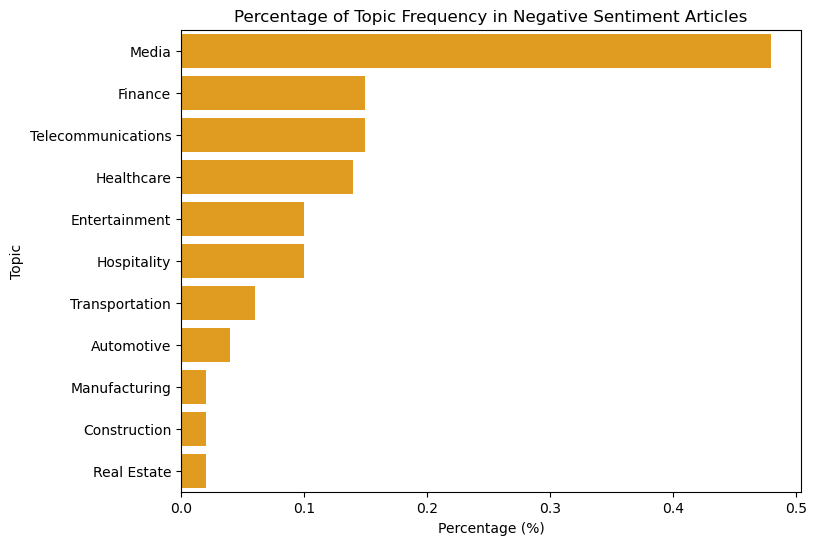

In [112]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the bar chart using Seaborn
sns.barplot(x='score', y='topic', data=neg_score.sort_values(by='score', ascending=False), color='orange')

# Add title and labels
plt.title('Percentage of Topic Frequency in Negative Sentiment Articles')
plt.xlabel('Percentage (%)')
plt.ylabel('Topic')

# Show the plot
plt.show()

### NER

In [102]:
# Named Entity Recognition (NER) function using SpaCy
def spacy_ner(text):
    doc = nlp1(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [219]:
# Extract entities from titles and texts of news articles separately
text_spacy = []
nlp1 = spacy.load("en_core_web_sm")
for idx, row in relevant_articles.iterrows():
    entities_text_spacy = spacy_ner(row['text'])
    for entity_tuple in entities_text_spacy:
        entity_dict = {'text': entity_tuple[0], 'label': entity_tuple[1]} 
        entity_dict['index'] = idx  
        text_spacy.append(entity_dict)

In [225]:
df_text_spacy = pd.DataFrame(text_spacy)
# Rename columns
df_text_spacy = df_text_spacy.rename(columns={'text': 'Entity', 'label': 'Source'})
df_text_spacy

In [227]:
# Top 20 entities group by entities and labels
df_text_spacy.groupby(['Entity', 'Source']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(20)

,Entity,Source,count
62935,AI,ORG,120374
463151,US,GPE,20484
509255,first,ORDINAL,13218
27119,2023,DATE,12773
519818,one,CARDINAL,12186
228890,Gray Media Group,ORG,11704
319121,Microsoft,ORG,11604
354279,OpenAI,GPE,10848
226062,Google,ORG,10723
3425,1,CARDINAL,10569


#### ORG

In [40]:
org_entities = df_text_spacy[df_text_spacy['Source'] == 'ORG'].groupby(['Entity', 'Source']).size().reset_index(name='count').sort_values('count', ascending=False).head(100)
org_entities

,Entity,Source,count
2708,AI,ORG,120374
90624,Gray Media Group,ORG,11704
128250,Microsoft,ORG,11604
88806,Google,ORG,10723
149623,PRNewswire,ORG,5894
...,...,...,...
121214,MIT,ORG,439
104380,Instagram,ORG,435
55450,CrushOn,ORG,434
137009,Netflix,ORG,434


In [45]:
# Drop entities irrelated to AI
org_irrelated = ['AI','Gray Media Group','Android','Gray Television , Inc','Gray Media Group , Inc.','Bard','PRNewswire','Altman',
                 'White House','Congress','FCC','NYSE','Artificial Intelligence','AP','ML','EU','Opens','Associated Press',
                 'Artificial Intelligence AI','ServicePrivacy','NPR','Trump','Reuters','Associated Press Posted','Nexstar Media Inc.'
                'LLC','LLC','NASDAQ','GPU','Bing','CNN','API','NLP','DIGI COMMUNICATIONS N.V.','DIGI','Healthcare'
                'AMD','SAS','Next','NavigationClose NavigationSearchPlease','AIML','FDA','AMD','NASA','European Union','SEC','AsiaPacific',
                'CaptioningAudio','MediaAll Entertainment','TX','RSS','House','IP']
org_entities = org_entities[~org_entities['Entity'].isin(org_irrelated)]
org_entities.head(20)

,Entity,Source,count
128250,Microsoft,ORG,11604
88806,Google,ORG,10723
17206,Amazon,ORG,3465
98695,IBM,ORG,3073
19762,Apple,ORG,2710
104823,Intel,ORG,1740
127656,Meta,ORG,1559
143541,Nvidia,ORG,1451
81913,GPT,ORG,1286
173298,Samsung,ORG,1222


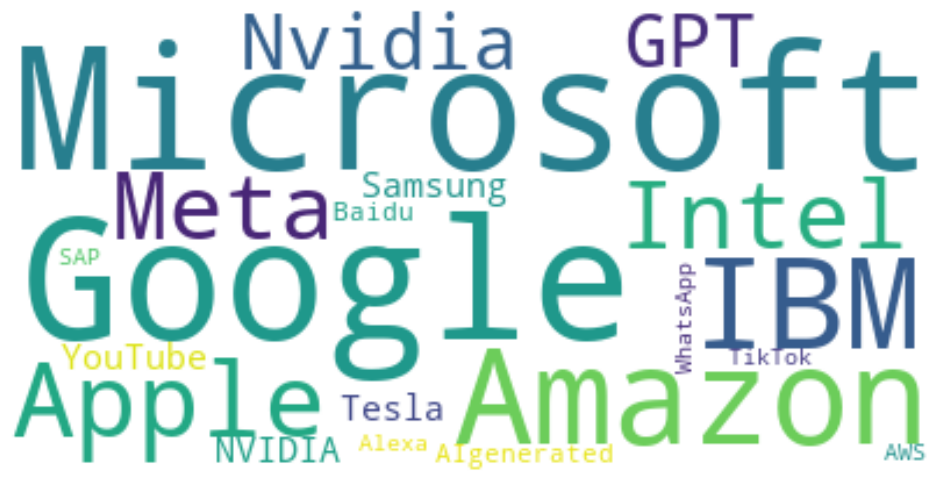

In [312]:
from wordcloud import WordCloud

# Prepare data for the word cloud
word_counts = org_entities.head(20).set_index('Entity')['count'].apply(np.sqrt).to_dict()

# Create a WordCloud object with custom parameters
wordcloud = WordCloud(
    max_font_size=80,            # Set maximum font size
    max_words=100,               # Limit the maximum number of words
    background_color='white',    # Set background color to white
    colormap='viridis',          # Choose a colormap for the word cloud
    contour_width=2,             # Set contour width
    contour_color='steelblue'    # Set contour color
)

# Generate the word cloud
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 8))    # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### PERSON

In [244]:
person_entities = df_text_spacy[df_text_spacy['Source'] == 'PERSON'].groupby(['Entity', 'Source']).size().reset_index(name='count').sort_values('count', ascending=False).head(100)
person_entities

,Entity,Source,count
108129,Sam Altman,PERSON,1953
15969,Biden,PERSON,1755
125271,Twitter,PERSON,1400
38786,Elon Musk,PERSON,1176
87619,Musk,PERSON,963
...,...,...,...
12200,Austin,PERSON,149
89401,Netanyahu,PERSON,149
110353,ScreenerOnline BrokersGlossarySustainable,PERSON,148
85576,Mira Murati,PERSON,147


In [261]:
# Drop entities irrelated to AI
person_irrelated = ['Twitter','CaptioningAudio','AI','DescriptionAt Gray','OpenAI','Generative AI','Snap',
                    'Google Cloud','AdvertisingAt Gray','Android Weather','Bloomberg','Newsfeed','Dashboard Profile',
                   'CDT','Midjourney','Size','MachineryMachine Tools','Taylor Swift','Pixel','Ventilation AirConditioning',
                    'Weather Alerts Alerts','Covid','Metalworking MetallurgyMiningMining','Machine Learning','Alert Weather'
                   'TravelAmusement Parks','WiFi','Privacy Policy','Siri','Anthropic']
person_entities = person_entities[~person_entities['Entity'].isin(person_irrelated)].head(20)
person_entities

,Entity,Source,count
108129,Sam Altman,PERSON,1953
15969,Biden,PERSON,1755
38786,Elon Musk,PERSON,1176
87619,Musk,PERSON,963
61529,Joe Biden,PERSON,656
35661,Donald Trump,PERSON,542
5189,Alert Maker,PERSON,390
109418,Satya Nadella,PERSON,361
118665,Sundar Pichai,PERSON,349
62849,Johnson,PERSON,342


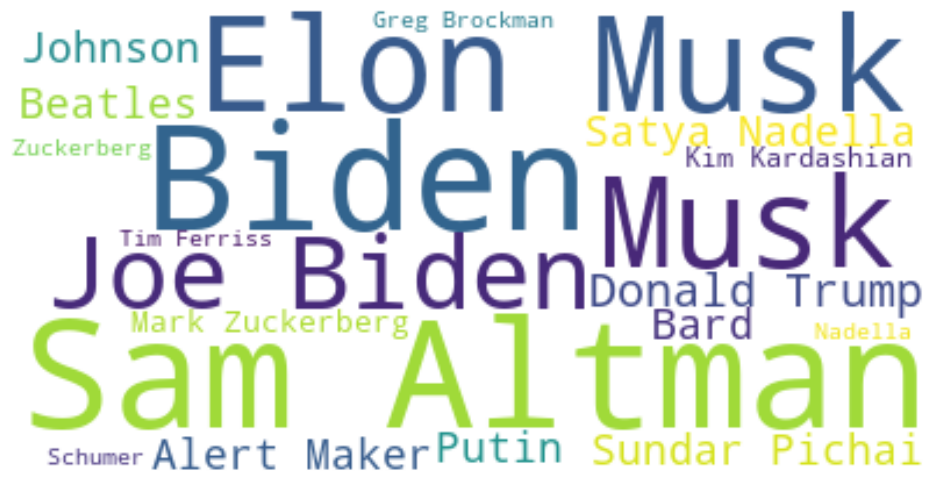

In [262]:
# Prepare data for the word cloud
word_counts = person_entities.set_index('Entity')['count'].apply(np.sqrt).to_dict()

# Create a WordCloud object with custom parameters
wordcloud = WordCloud(
    max_font_size=80,            # Set maximum font size
    max_words=100,               # Limit the maximum number of words
    background_color='white',    # Set background color to white
    colormap='viridis',          # Choose a colormap for the word cloud
    contour_width=2,             # Set contour width
    contour_color='steelblue'    # Set contour color
)

# Generate the word cloud
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 8))    # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### GPE

In [264]:
gpe_entities = df_text_spacy[df_text_spacy['Source'] == 'GPE'].groupby(['Entity', 'Source']).size().reset_index(name='count').sort_values('count', ascending=False).head(100)
gpe_entities

,Entity,Source,count
16309,US,GPE,20484
11725,OpenAI,GPE,10848
16199,U.S.,GPE,6950
6954,India,GPE,6852
3100,China,GPE,6436
...,...,...,...
10686,Netherlands,GPE,353
9302,Malaysia,GPE,344
7182,Iran,GPE,343
5534,GenAI,GPE,341


In [269]:
# Drop entities irrelated to AI
gpe_irrelated = ['OpenAI']
gpe_entities = gpe_entities[~gpe_entities['Entity'].isin(gpe_irrelated)].head(20)
gpe_entities

,Entity,Source,count
16309,US,GPE,20484
16199,U.S.,GPE,6950
6954,India,GPE,6852
3100,China,GPE,6436
16257,UK,GPE,4159
16673,Us,GPE,3340
16568,United States,GPE,2591
10875,New York,GPE,2434
2785,Canada,GPE,2268
2735,California,GPE,2172


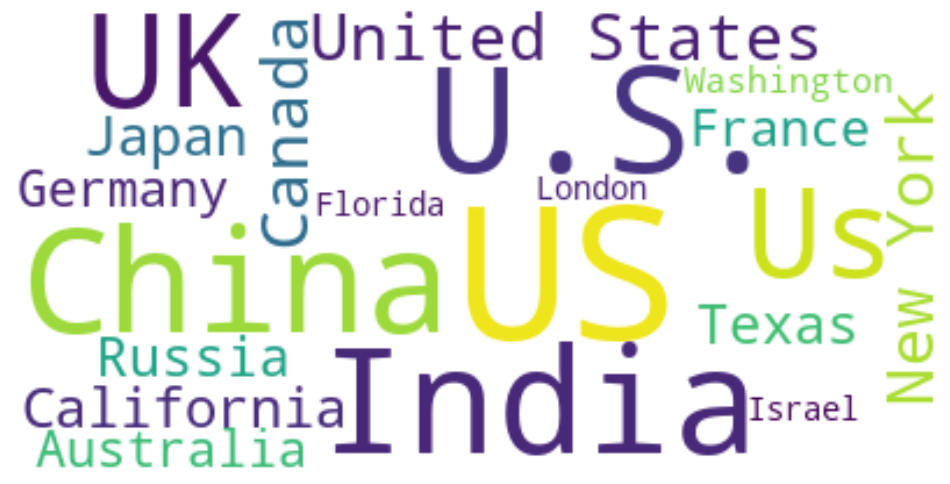

In [270]:
# Prepare data for the word cloud
word_counts = gpe_entities.set_index('Entity')['count'].apply(np.sqrt).to_dict()

# Create a WordCloud object with custom parameters
wordcloud = WordCloud(
    max_font_size=80,            # Set maximum font size
    max_words=100,               # Limit the maximum number of words
    background_color='white',    # Set background color to white
    colormap='viridis',          # Choose a colormap for the word cloud
    contour_width=2,             # Set contour width
    contour_color='steelblue'    # Set contour color
)

# Generate the word cloud
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 8))    # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### PRODUCT

In [46]:
product_entities = df_text_spacy[df_text_spacy['Source'] == 'PRODUCT'].groupby(['Entity', 'Source']).size().reset_index(name='count').sort_values('count', ascending=False).head(100)
product_entities

,Entity,Source,count
13786,Twitter,PRODUCT,1119
1258,Altman,PRODUCT,575
11854,ServicePrivacy,PRODUCT,548
6728,IssuesAcquisitions,PRODUCT,353
12827,Subscribe,PRODUCT,340
...,...,...,...
13153,TeamCozi,PRODUCT,40
9488,P Global,PRODUCT,40
1092,Ai,PRODUCT,39
9238,NoticeYour,PRODUCT,39


In [89]:
# Drop entities irrelated to AI
product_irrelated = ['Twitter','CRM','Altman','ServicePrivacy','IssuesAcquisitions','Subscribe','Click','CancelRead','NextRead','AgencyFor',
                    'Fortune 500','Excel','Windows 11','Cancel','RentLabor IssuesTrouble','InsightsNews Insights Markets Companies','NewsPlugin']
product_entities = product_entities[~product_entities['Entity'].isin(product_irrelated)]
product_entities.head(20)

,Entity,Source,count
5610,GPT4,PRODUCT,243
6799,JavaScript,PRODUCT,226
3903,DeepMind,PRODUCT,216
5951,Google Cloud,PRODUCT,193
7480,Llama 2,PRODUCT,157
4030,Discovery,PRODUCT,151
3883,DeepBrain AI,PRODUCT,147
9783,PhotoRichard Drew,PRODUCT,142
2144,Bollinger Bands,PRODUCT,114
3034,Claude,PRODUCT,109


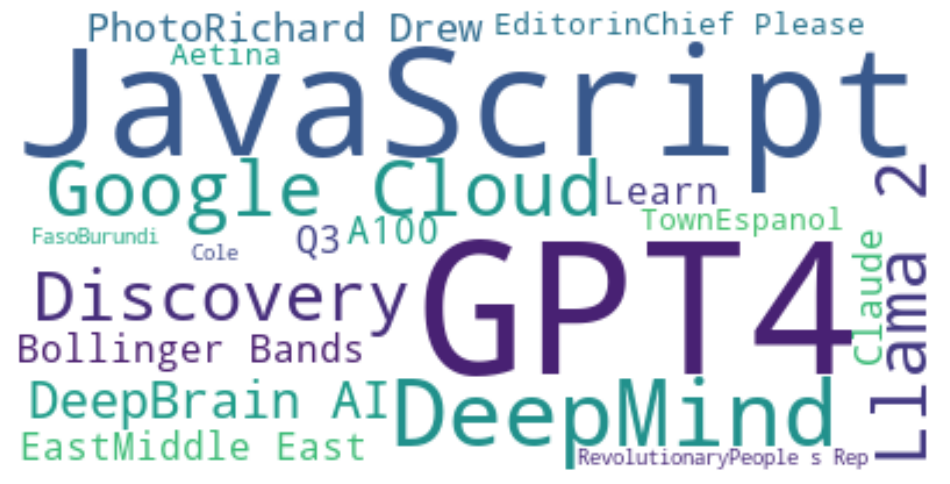

In [450]:
# Prepare data for the word cloud
word_counts = product_entities.head(20).set_index('Entity')['count'].apply(np.sqrt).to_dict()

# Create a WordCloud object with custom parameters
wordcloud = WordCloud(
    max_font_size=80,            # Set maximum font size
    max_words=100,               # Limit the maximum number of words
    background_color='white',    # Set background color to white
    colormap='viridis',          # Choose a colormap for the word cloud
    contour_width=2,             # Set contour width
    contour_color='steelblue'    # Set contour color
)

# Generate the word cloud
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 8))    # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Timeline

In [92]:
AI_entities = pd.concat([product_entities.head(10),org_entities.head(20)], axis=0)['Entity'].tolist()

In [357]:
# Extract entity
AI_ner = df_text_spacy[df_text_spacy['Entity'].isin(AI_entities)]
AI_ner

,Entity,Source,index
166,Intel,ORG,128695
171,Intel,ORG,128695
175,Intel,ORG,128695
203,Microsoft,ORG,128695
219,Intel,ORG,128695
...,...,...,...
2352780,Google,ORG,18834
2352782,Google,ORG,18834
2352785,Google,ORG,18834
2352790,Google,ORG,18834


In [114]:
# Extract date
index_date=relevant_articles.reset_index()[['index', 'date']]
index_date['date'] = pd.to_datetime(index_date['date'])
# Change the date column as the format like year-month
index_date['month'] = index_date['date'].dt.strftime('%Y-%m')
index_date

,index,date,month
0,142557,2022-08-30,2022-08
1,82615,2021-10-28,2021-10
2,57523,2023-08-20,2023-08
3,3204,2023-03-24,2023-03
4,49464,2023-06-23,2023-06
...,...,...,...
20002,78328,2022-02-01,2022-02
20003,112323,2022-07-06,2022-07
20004,164646,2023-08-17,2023-08
20005,16854,2020-11-12,2020-11


In [359]:
# Combine entity and date
AI_date = pd.merge(AI_ner, index_date, on='index', how='left')
AI_date

,Entity,Source,index,date,month
0,Intel,ORG,128695,2024-01-10,2024-01
1,Intel,ORG,128695,2024-01-10,2024-01
2,Intel,ORG,128695,2024-01-10,2024-01
3,Microsoft,ORG,128695,2024-01-10,2024-01
4,Intel,ORG,128695,2024-01-10,2024-01
...,...,...,...,...,...
51922,Google,ORG,18834,2023-02-01,2023-02
51923,Google,ORG,18834,2023-02-01,2023-02
51924,Google,ORG,18834,2023-02-01,2023-02
51925,Google,ORG,18834,2023-02-01,2023-02


In [379]:
# get the article count of AI entities by date
AI_month_count=AI_date.groupby(['month', 'Entity']).size().reset_index().rename(columns={0:'count'}).sort_values('month', ascending=True)
AI_month_count

,month,Entity,count
0,2020-01,AIgenerated,2
20,2020-01,YouTube,19
19,2020-01,WhatsApp,5
18,2020-01,TikTok,2
17,2020-01,Tesla,6
...,...,...,...
1364,2024-02,Amazon,24
1363,2024-02,Alexa,2
1362,2024-02,AIgenerated,5
1370,2024-02,Intel,2


/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

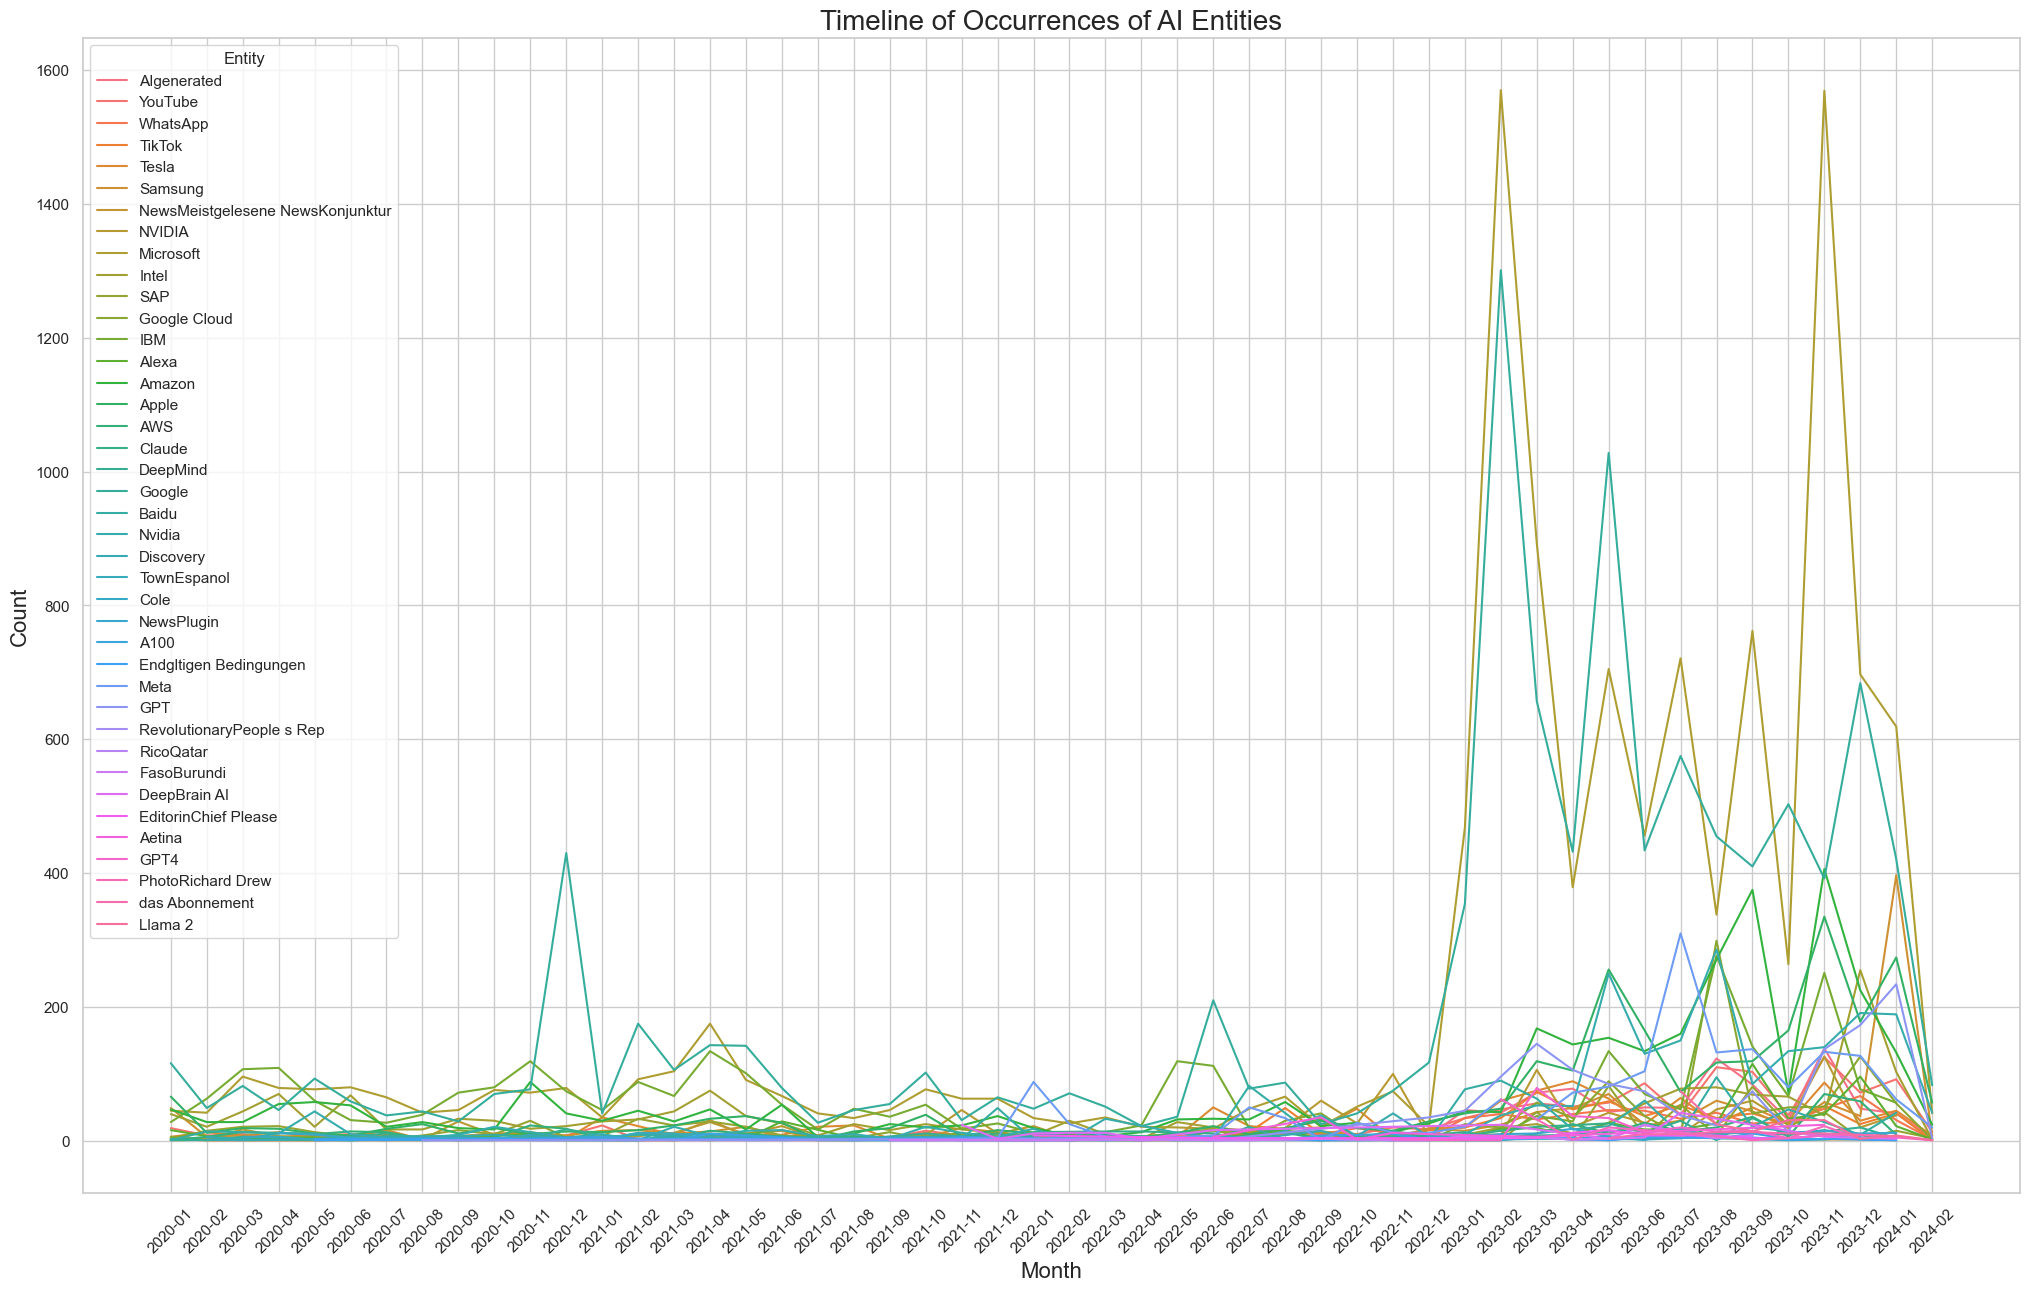

<module 'matplotlib.pyplot' from '/Users/yifan_/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [383]:
import seaborn as sns

plt.figure(figsize=(25,15))  # Increase the size of the plot
sns.set(style="whitegrid")
sns.lineplot(data=AI_month_count, x='month', y='count', hue='Entity')
plt.title('Timeline of Occurrences of AI Entities', fontsize=20)  # Set title and font size
plt.xlabel('Month', fontsize=16)  # Set x-axis label and font size
plt.ylabel('Count', fontsize=16)  # Set y-axis label and font size
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.savefig('timeline_plot.png')
plt.show()
plt

In [380]:
AI_date_count=AI_date.groupby(['date', 'Entity']).size().reset_index().rename(columns={0:'count'}).sort_values('date', ascending=True)
AI_date_count
# Find the record with the maximum count for each entity
max_count_dates = AI_date_count.loc[AI_date_count.groupby('Entity')['count'].idxmax()].sort_values('date', ascending=True)

In [391]:
max_count_dates = max_count_dates[max_count_dates['count'] >= 20]

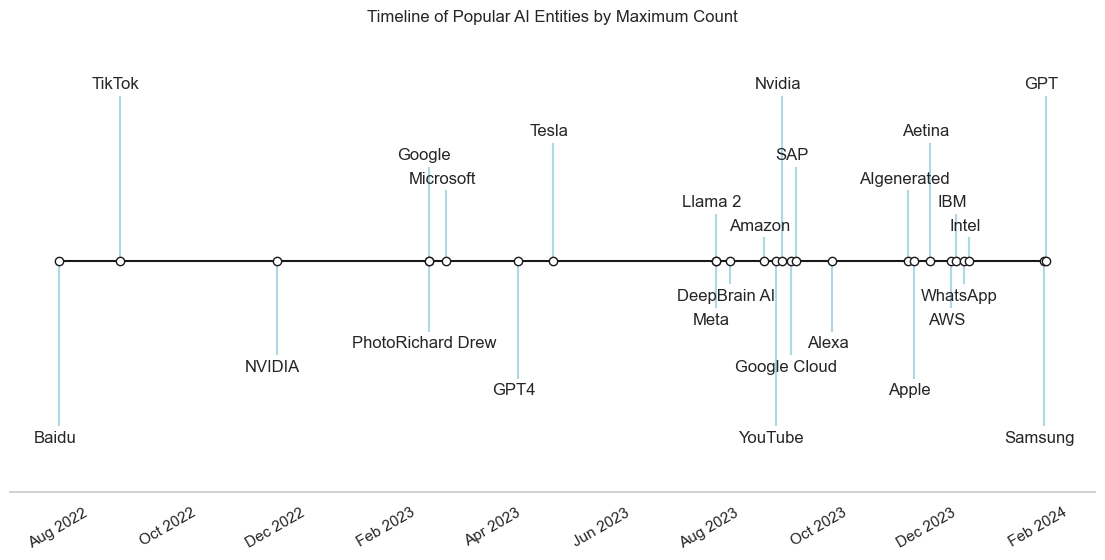

In [409]:

# Choose some nice levels
levels = np.tile([-14, 14, -8, 8, -6, 6, -10, 10, -4, 4, -2, 2],
                 int(np.ceil(len(max_count_dates['date'])/12)))[:len(max_count_dates['date'])]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(14, 6))
ax.set(title="Timeline of Popular AI Entities by Maximum Count")

ax.vlines(max_count_dates['date'], 0, levels, color="tab:orange")  # The vertical stems.
ax.plot(max_count_dates['date'], np.zeros_like(max_count_dates['date']), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# Annotate lines
for d, l, r in zip(max_count_dates['date'], levels, max_count_dates['Entity']):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l > 0 else "top")

# Format x-axis with 2-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

# Remove background vertical lines
ax.grid(axis='x', color='white')

ax.margins(y=0.2)
plt.show()


### Entity targeted sentiment

In [84]:
# Load the English model of spaCy
nlp2 = spacy.load("en_core_web_sm", disable=['parser', 'tagger'])
import warnings
# Create an empty DataFrame to store the NER results
ner_results = pd.DataFrame(columns=['Entity', 'text', 'Source', 'index'])

# Perform NER analysis on each line of text
for index, row in relevant_articles.iterrows():
    doc = nlp(row['text'])

# 忽略特定类型的警告
    warnings.filterwarnings("ignore", category=UserWarning)

    # Perform NER analysis on each sentence
    for sent in doc.sents:
        sent_text = sent.text
        sent_doc = nlp2(sent_text)
        for ent in sent_doc.ents:
            ner_results = pd.concat([ner_results, pd.DataFrame({'Entity': [ent.text],
                                                                'Source': [ent.label_],
                                                                'text': [sent_text],
                                                                'index': [row['index']]})],
                                    ignore_index=True)


In [36]:
# make class predictions
y_pred = svm.predict(vect.transform(ner_results['text']))
# Add the predictions to the relevant_articles DataFrame
ner_results['sentiment'] = y_pred

In [76]:
ner_results_filtered = ner_results[ner_results['Entity'].isin(AI_entities)]
ner_results_filtered = ner_results_filtered[ner_results_filtered['Source'].isin(['ORG','PRODUCT'])]
ner_results_filtered['sentiment'] = ner_results_filtered['sentiment'].replace(0, -1)
ner_results_filtered.head(5)

,Entity,text,Source,index,sentiment
26,Google,"Since October last year , country government ...",ORG,142557,-1
58,Google,Share Facebook Twitter Stumbleupon LinkedIn Pi...,ORG,142557,-1
106,Intel,Intel CorporationIBM CorporationMicrosoftGoogl...,ORG,82615,-1
602,Microsoft,"AWS long leader public cloud sector , Microsof...",ORG,17708,-1
606,Google,Google used AI internally years released chatb...,ORG,17708,1


In [116]:
# Combine entity and date
ner_time = pd.merge(ner_results_filtered, index_date, on='index', how='left')
ner_time

,Entity,text,Source,index,sentiment,date,month
0,Google,"Since October last year , country government ...",ORG,142557,-1,2022-08-30,2022-08
1,Google,Share Facebook Twitter Stumbleupon LinkedIn Pi...,ORG,142557,-1,2022-08-30,2022-08
2,Intel,Intel CorporationIBM CorporationMicrosoftGoogl...,ORG,82615,-1,2021-10-28,2021-10
3,Microsoft,"AWS long leader public cloud sector , Microsof...",ORG,17708,-1,2023-06-24,2023-06
4,Google,Google used AI internally years released chatb...,ORG,17708,1,2023-06-24,2023-06
...,...,...,...,...,...,...,...
11772,Tesla,"recent years , GPT3 language model OpenAI , la...",ORG,122033,-1,2022-06-14,2022-06
11773,Google,Putting emphasis AI sentience would given Goog...,ORG,122033,-1,2022-06-14,2022-06
11774,Apple,TexasBusiness Technology : look bots holding ...,ORG,122033,-1,2022-06-14,2022-06
11775,Google,", researchers said , Google LaMDA technology ...",ORG,122033,-1,2022-06-14,2022-06


In [115]:
aggregated_sentiment = ner_results_filtered.groupby(['Entity', 'Source'])['sentiment'].mean().reset_index()
aggregated_sentiment.head(5)

,Entity,Source,sentiment
0,A100,PRODUCT,-0.250000
1,AIgenerated,ORG,-0.593074
2,AWS,ORG,-0.547445
3,Aetina,PRODUCT,0.500000
4,Alexa,ORG,-0.518519


In [103]:
aggregated_sentiment=aggregated_sentiment.drop([37])
aggregated_sentiment

,Entity,Source,sentiment
0,A100,PRODUCT,-0.250000
1,AIgenerated,ORG,-0.593074
2,AWS,ORG,-0.547445
3,Aetina,PRODUCT,0.500000
4,Alexa,ORG,-0.518519
5,Amazon,ORG,-0.657702
6,Apple,ORG,-0.115328
7,Baidu,ORG,-0.360996
9,Claude,ORG,-0.777778
10,Claude,PRODUCT,-0.818182


/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yifan_/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

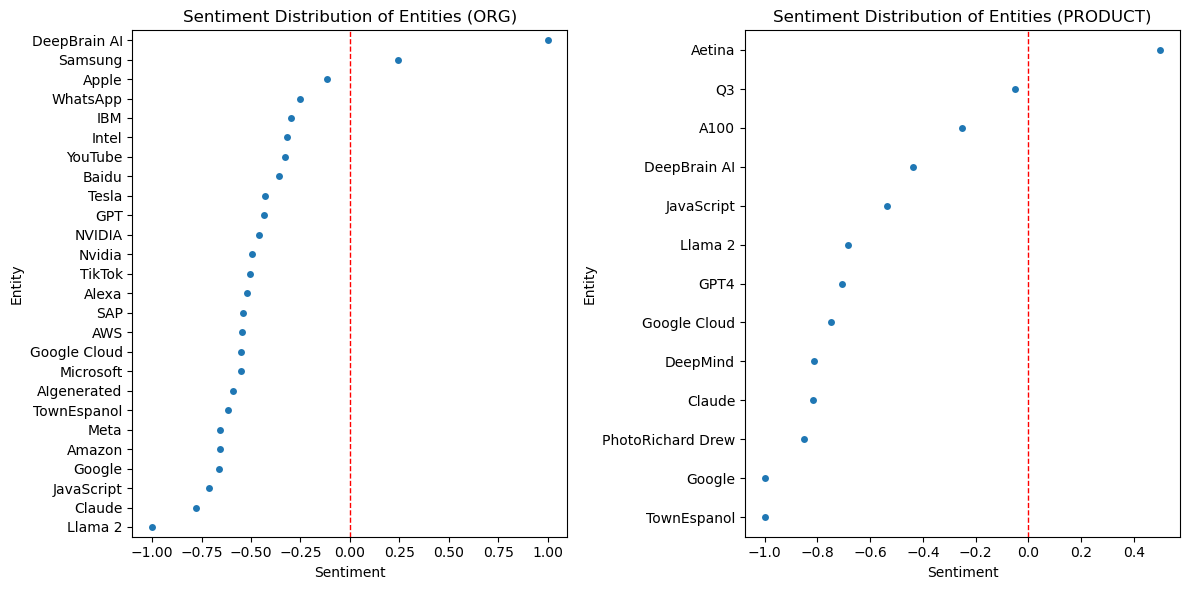

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sorting by sentiment value to place the entity with the highest sentiment at the top
org_sentiment_sorted = aggregated_sentiment[aggregated_sentiment['Source']=='ORG'].sort_values(by='sentiment', ascending=False)
product_sentiment_sorted = aggregated_sentiment[aggregated_sentiment['Source']=='PRODUCT'].sort_values(by='sentiment', ascending=False)

# Plotting two charts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.stripplot(data=org_sentiment_sorted, y='Entity', x='sentiment', jitter=True, orient='h')
plt.title('Sentiment Distribution of Entities (ORG)')
plt.xlabel('Sentiment')
plt.ylabel('Entity')
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)  # Drawing a reference line at sentiment=0

plt.subplot(1, 2, 2)
sns.stripplot(data=product_sentiment_sorted, y='Entity', x='sentiment', jitter=True, orient='h')
plt.title('Sentiment Distribution of Entities (PRODUCT)')
plt.xlabel('Sentiment')
plt.ylabel('Entity')
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)  # Drawing a reference line at sentiment=0

plt.tight_layout()
plt.show()
